In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
train_data = pd.read_csv("train.csv")
train_data.head()

,Id,difficulty,ciphertext,target
0,ID_88b9bbd73,4,"ob|I K?zzhX*L{83B3Z,FuL*Pusm$83L\t@r$$*38,8s...",10
1,ID_f489bd59f,1,c1|FaAO120O'8ovfoy1W#atvGs1[1s1[1/1]O-a8o1-...,13
2,ID_f90fee9c7,2,1*e4N8$f$0ccOuihkHek$k*V*hoeV$Hj8VhH8...,19
3,ID_8303ced65,1,O8v^10O#to1'#^'^tv1^]s111t01Otaq>-ata_1...,17
4,ID_72abc2cb7,2,eV}H}khfe4b8'S.Vc}{A .#VikV.fV?{$f7$Hjb8...,0


In [3]:
data_by_level = {difficulty: train_data[train_data["difficulty"] == difficulty] for difficulty in train_data["difficulty"].unique()}
print(f"Available difficulties: {data_by_level.keys()}")

Available difficulties: dict_keys([4, 1, 2, 3])


In [4]:
data_by_level[1].head()

,Id,difficulty,ciphertext,target
1,ID_f489bd59f,1,c1|FaAO120O'8ovfoy1W#atvGs1[1s1[1/1]O-a8o1-...,13
3,ID_8303ced65,1,O8v^10O#to1'#^'^tv1^]s111t01Otaq>-ata_1...,17
13,ID_850984d77,1,*#^-G1_#O-#b^'ta8af2%e1|28Oot^12#O-#ys1>c...,18
15,ID_f61f4e2ab,1,*#^-G1\HL\5b#Oz8cA8Ac1|>O-c81 ^vvys1>cX...,6
16,ID_d87237dcc,1,1A]v-O1vT101-OA1#^^fas1-avtOfvT1c...,10


## Difficulty 1

Notice how rows 13 and 15 share the same beggining

In [5]:
train_data.iloc[[13, 15]]

,Id,difficulty,ciphertext,target
13,ID_850984d77,1,*#^-G1_#O-#b^'ta8af2%e1|28Oot^12#O-#ys1>c...,18
15,ID_f61f4e2ab,1,*#^-G1\HL\5b#Oz8cA8Ac1|>O-c81 ^vvys1>cX...,6


This hints that the difficulty 1 challenges may be encrypted with simple letter substitutions. Let's assume that is the case and see where it leads us.

One of the easiest ways to encrypt text is to shift all letters by a given number (wrapping around at the end of the alphabet). Since we are dealing with bytes, there are only 256 possible shifts - completely _bruteforceable_. 

In [6]:
cipher_sample = data_by_level[1]["ciphertext"].tolist()[0]
print(f"Cipher length: {len(cipher_sample)}")
print(cipher_sample)

Cipher length: 300
c1|FaAO120O'8ovfoy1W#atvGs1[1s1[1/1]O-a8o1--#1^]1-a1av1vc]]#ad1]#^-1O1vz#1A'#vva^1#^cd0t1^s1[1o1-^'Ocv1Ov1W881Ov1O1-tO81#Of1A^W11>01av1ad1t#OtA1Wat0s1[1gO8oA^81Wat01v^-1vc__vv1ct1t01t#Ot-tv1ad1'#^zaAA1t0#^cd010#s1[1'vo_0aOt#avt1O#1^t1vOtav]O_t^#11>^-


In [7]:
cipher_bytes = cipher_sample.encode()
for i in range(256):
    shifted_cipher = "".join([chr((c + i)%256) for c in cipher_bytes])
    # Commented for brevity
    #print(f"{'-'*100}\nShift by: {i}\n{shifted_cipher}\n{'-'*100}")

It doesn't seem like the ecryption is merely a shift.

To check if it actually is a substitution cipher, we could analyse the frequency of characters.

102 unique characters in ciphertexts


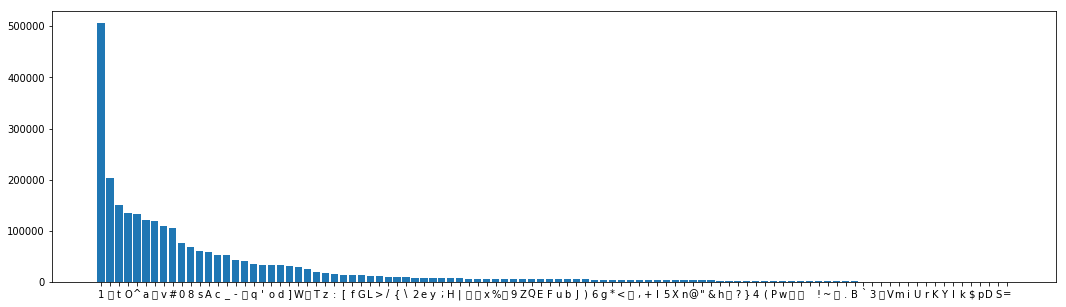

In [8]:
from collections import Counter

char_count = Counter("".join(data_by_level[1]["ciphertext"].values))
ordered_cipher_chars = list(zip(*sorted(char_count.items(), key=lambda x: -x[1])))
print(f"{len(char_count)} unique characters in ciphertexts")
plt.figure(figsize=(18,5))
plt.bar(range(len(char_count)), ordered_cipher_chars[1])
plt.xticks(range(len(char_count)), ordered_cipher_chars[0])
plt.show()

Now, could compare this histogram to the frequencies of letters in English. However, we know these ciphertexts were created on the 20 Newsgroups dataset. So an even better idea would be to compare these frequencies to the frequencies of letters from the plain text dataset.

In [10]:
from sklearn.datasets import fetch_20newsgroups

plain_data = fetch_20newsgroups(subset='all')

156 unique characters in plain texts


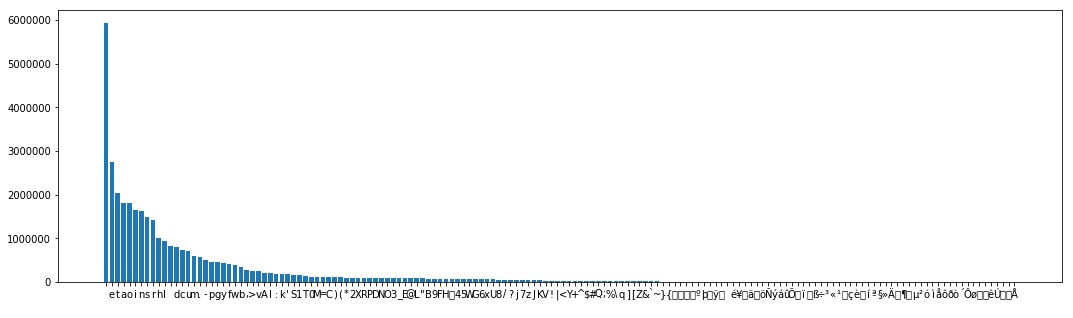

In [30]:
plain_char_count = Counter("".join(plain_data["data"]))
ordered_plain_chars = list(zip(*sorted(plain_char_count.items(), key=lambda x: -x[1])))
print(f"{len(plain_char_count)} unique characters in plain texts")
plt.figure(figsize=(18,5))
plt.bar(range(len(plain_char_count)), ordered_plain_chars[1])
plt.xticks(range(len(plain_char_count)), ordered_plain_chars[0])
plt.show()

We can now create a correspondence mapping between both distributions.

In [33]:
cipher_to_plain = dict(zip(ordered_cipher_chars[0], ordered_plain_chars[0]))
cipher_to_plain

{'1': ' ',
 '\x1b': 'e',
 't': 't',
 'O': 'a',
 '^': 'o',
 'a': 'i',
 '\x02': 'n',
 'v': 's',
 '#': 'r',
 '0': 'h',
 '8': 'l',
 's': '\n',
 'A': 'd',
 'c': 'c',
 '_': 'u',
 '-': 'm',
 '\x08': '.',
 'q': '-',
 "'": 'p',
 'o': 'g',
 'd': 'y',
 ']': 'f',
 'W': 'w',
 '\x03': 'b',
 'T': ',',
 'z': '>',
 ':': 'v',
 '[': 'A',
 'f': 'I',
 'G': ':',
 'L': 'k',
 '>': "'",
 '/': 'S',
 '{': '1',
 '\\': 'T',
 '2': '0',
 'e': 'M',
 'y': '=',
 ';': 'C',
 'H': ')',
 '|': '(',
 '\x1c': '*',
 '\x1e': '2',
 'x': 'X',
 '%': 'R',
 '\x7f': 'P',
 '9': 'D',
 'Z': 'N',
 'Q': 'O',
 'E': '3',
 'F': '_',
 'u': 'E',
 'b': '@',
 'J': 'L',
 ')': '"',
 '6': 'B',
 'g': '9',
 '*': 'F',
 '<': 'H',
 '\t': '\t',
 ',': '4',
 '+': '5',
 'l': 'W',
 '5': 'G',
 'X': '6',
 'n': 'x',
 '@': 'U',
 '"': '8',
 '&': '/',
 'h': '?',
 '\x06': 'j',
 '?': '7',
 '}': 'z',
 '4': 'J',
 '(': 'K',
 'P': 'V',
 'w': '!',
 '\x18': '|',
 '\x10': '<',
 ' ': 'Y',
 '!': '+',
 '~': '^',
 '\x1a': '$',
 '.': '#',
 'B': 'Q',
 '`': ';',
 '3': '%',
 '\x0c